In [1]:
from string import digits
import acquire
import prepare
import requests
from requests import get
from bs4 import BeautifulSoup
import os
import pandas as pd
import itertools
import re
import unicodedata
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords
from wordcloud import WordCloud

from scipy import stats
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

plt.rc('figure', figsize=(8, 10))

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#### Notes on Prepare/ Acquire: Create the URL's

- Focused on URL's that were identified as JavaScript or Python
- Opened up searh URL on GitHub, added URLs that fit discription untill 105 were sampled
- Ended on search page 39

## Acquire/Prepare:

In [2]:
urls = acquire.get_urls()
df = acquire.get_readme_articles(urls=urls, cached=True)
df = prepare.clean_data(df)
train, validate, test = prepare.train_validate_test(df)
train.shape, validate.shape, test.shape

((63, 2), (21, 2), (21, 2))

In [3]:
# Lets see what we are playing with
print(train.language.value_counts())
print(validate.language.value_counts())
print(test.language.value_counts())
train.head()

javascript    34
python        29
Name: language, dtype: int64
javascript    12
python         9
Name: language, dtype: int64
javascript    12
python         9
Name: language, dtype: int64


,language,text_filtered
29,javascript,reduxcode companion repo course udemy
85,javascript,npmhub npmhub browser extension let explore np...
45,javascript,archived content repo merged ipfsjsipfs please...
5,python,ipython productive interactive computing overv...
28,javascript,github doc repository contains documentation w...


## Explore:


1. What are the most common words in READMEs?
2. What does the distribution of IDFs look like for the most common words?
3. Does the length of the README vary by programming language?
4. Do different programming languages use a different number of unique words?

### Question #1. What are the most common words in READMEs?

In [4]:
# Break it down by language
#train['language'] = train['language'].str.strip()

In [5]:
# Create a corpus of all text
all_words = ' '.join(train.text_filtered)
all_words = re.sub(r'\s.\s', '', all_words)

In [6]:
# Expplore corpus
all_freq = pd.Series(all_words.split()).value_counts()
all_freq.head()

pod          434
use          221
file         214
run          192
container    166
dtype: int64

#### Javascript only

In [7]:
# Break it down by language (Javascript)
mask = train.language == 'javascript'
java_df = train[mask]
# Create a corpus of all text
all_words = ' '.join(java_df.text_filtered)
all_words = re.sub(r'\s.\s', '', all_words)
# Expplore corpus
all_freq = pd.Series(all_words.split()).value_counts()
all_freq.head()

pod          434
node         146
label        136
container    131
option       130
dtype: int64

In [8]:
# Word counts
word_counts = (pd.concat([all_freq], axis=1, sort=True)
               .set_axis(['all'], axis=1, inplace=False)
               .fillna(0)
               .apply(lambda s: s.astype(int))
              )
word_counts.sort_values(by='all', ascending=False).head(10)

,all
pod,434
node,146
label,136
container,131
option,130
file,127
use,112
kubectl,110
using,106
kubernetes,105


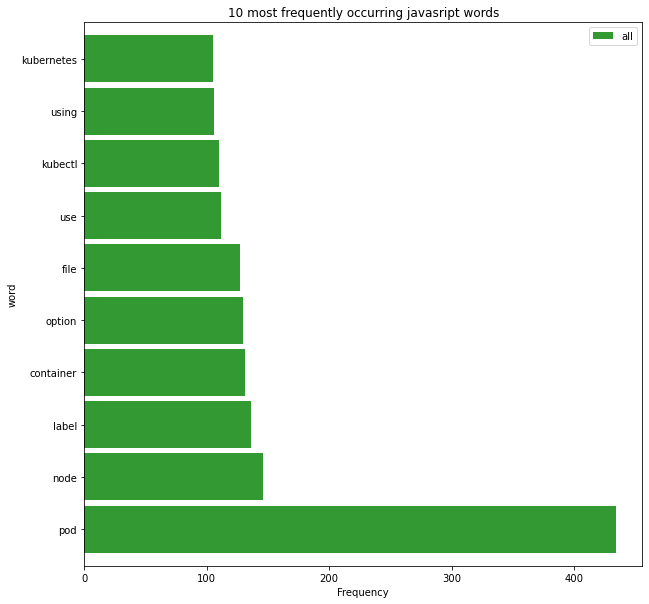

In [9]:
word_counts = word_counts.sort_values(by='all', ascending=False).head(10)
word_counts.plot.barh(color='green', width=.9, figsize=(10, 10), alpha=.8)
plt.title('10 most frequently occurring javasript words')
plt.ylabel('word')
plt.xlabel('Frequency')
plt.show()

****

#### Python Only

In [10]:
# Break it down by language (Python)
mask = train.language == 'python'
python_df = train[mask]
python_df.head()
# Create a corpus of all text
all_words = ' '.join(python_df.text_filtered)
all_words = re.sub(r'\s.\s', '', all_words)
# Expplore corpus
all_freq = pd.Series(all_words.split()).value_counts()
all_freq.head()

use       109
python     93
run        91
file       87
git        85
dtype: int64

In [11]:
# Word counts
word_counts = (pd.concat([all_freq], axis=1, sort=True)
               .set_axis(['all'], axis=1, inplace=False)
               .fillna(0)
               .apply(lambda s: s.astype(int))
              )
word_counts.sort_values(by='all', ascending=False).head(10)

,all
use,109
python,93
run,91
file,87
git,85
code,78
model,66
repo,65
command,64
data,63


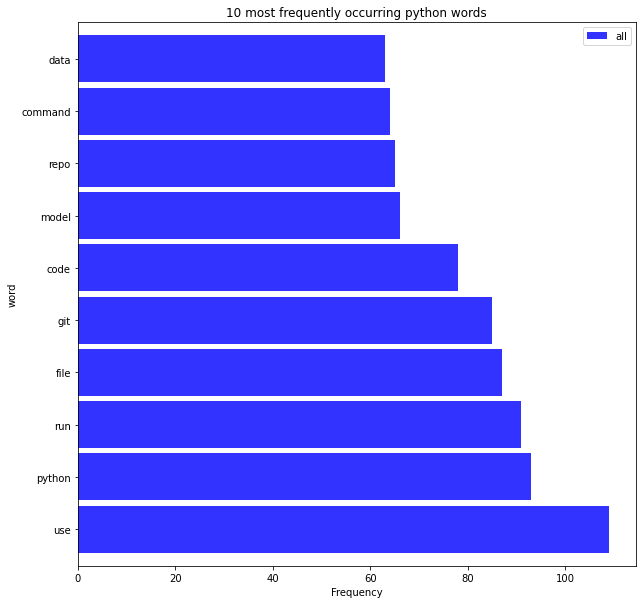

In [12]:
word_counts = word_counts.sort_values(by='all', ascending=False).head(10)
word_counts.plot.barh(color='blue', width=.9, figsize=(10, 10), alpha=.8)
plt.title('10 most frequently occurring python words')
plt.ylabel('word')
plt.xlabel('Frequency')
plt.show()

#### Combined 

In [13]:
# Create Corpus
javascript_words = ' '.join(train[train.language =='javascript'].text_filtered)
python_words = ' '.join(train[train.language =='python'].text_filtered)
all_words = ' '.join(train.text_filtered)
javascript_words = re.sub(r'\s.\s', '', javascript_words)
python_words = re.sub(r'\s.\s', '', python_words)
all_words = re.sub(r'\s.\s', '', all_words)

# Explore corpus
javascript_freq = pd.Series(javascript_words.split()).value_counts()
python_freq = pd.Series(python_words.split()).value_counts()
all_freq = pd.Series(all_words.split()).value_counts()
word_counts = (pd.concat([all_freq, javascript_freq, python_freq], axis=1, sort=True)
               .set_axis(['all', 'javascript', 'python'], axis=1, inplace=False)
               .fillna(0)
               .apply(lambda s: s.astype(int))
              )


# How often to words occur across repos
word_counts.sort_values(by='all', ascending=False).head(10)

,all,javascript,python
pod,434,434,0
use,221,112,109
file,214,127,87
run,192,101,91
container,166,131,35
using,164,106,58
see,154,101,53
new,154,99,55
option,150,130,20
node,146,146,0


In [14]:
# Any words specific only to javascript and never in python?
word_counts[word_counts.python == 0].sort_values(by='javascript', ascending=False).head(10)

,all,javascript,python
pod,434,434,0
node,146,146,0
kubectl,110,110,0
kubernetes,105,105,0
replicationcontroller,86,86,0
selector,59,59,0
probe,57,57,0
npm,51,51,0
params,51,51,0
listing,45,45,0


In [15]:
# Any words specific only to python and never in javascript?
word_counts[word_counts.javascript == 0].sort_values(by='python', ascending=False).head(10)

,all,javascript,python
model,66,0,66
gita,48,0,48
ipython,41,0,41
lineprofiler,38,0,38
emotion,38,0,38
viz,34,0,34
fastexport,30,0,30
filterbranch,29,0,29
repokid,29,0,29
2019,28,0,28


In [16]:
# These might be words to excude to make modeling easier
word_counts[word_counts.javascript == word_counts.python].sort_values(by='python', ascending=False).head(20)

,all,javascript,python
output,48,24,24
first,44,22,22
library,40,20,20
page,20,10,10
requires,14,7,7
etc,12,6,6
standard,12,6,6
mean,12,6,6
back,10,5,5
across,10,5,5


****
#### Takeaway:

`1. Top 10 Javascript words (file, option, use, npm, using, run, callback, meta, new, install)`   
`2. Top 10 Python words     (file, video, use, youtubed, download, git, formatt, python, run, command)`    
`3. Common words, bad for modeling (file, use, run, using, example)`     
`4. Most common words (Corpus) = Most Common words for specific languages`    

`May remove flie, use, run, using, example from corpus`   

****

### Question #2. What does the distribution of IDFs look like for the most common words?

In [17]:
#Inverse Documnet Frequency; a measure based on in how many documents will a word appear.

from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(stop_words='english', min_df=20, 
                             ngram_range=(1,2), 
                             binary=True)

tfidf_sparse_matrix = tfidf.fit_transform(train.text_filtered)

In [18]:
# Get vocabularies.
tfidf.vocabulary_

{'repo': 29,
 'github': 14,
 'repository': 30,
 'file': 12,
 'installation': 19,
 'version': 41,
 'work': 43,
 'using': 40,
 'like': 22,
 'different': 9,
 'open': 27,
 'issue': 20,
 'change': 3,
 'code': 5,
 'set': 33,
 'install': 18,
 'source': 34,
 'example': 10,
 'license': 21,
 'support': 35,
 'need': 24,
 'used': 39,
 'check': 4,
 'run': 32,
 'use': 38,
 'request': 31,
 'following': 13,
 'note': 26,
 'make': 23,
 'information': 17,
 'want': 42,
 'data': 8,
 'add': 0,
 'help': 16,
 'project': 28,
 'time': 36,
 'create': 7,
 'command': 6,
 'update': 37,
 'feature': 11,
 'automatically': 1,
 'new': 25,
 'build': 2,
 'ha': 15}

***
#### Takeaway:
`1. Many of the words are overlap are found in many documents, further evidence that they should be removed befor modeling`

***

### Question #3. Does the length of the README vary by programming language?

In [19]:
# Count lenght of readme text
train['doc_length'] = [len(wordlist) for wordlist in train.text_filtered]
train.head()

,language,text_filtered,doc_length
29,javascript,reduxcode companion repo course udemy,37
85,javascript,npmhub npmhub browser extension let explore np...,580
45,javascript,archived content repo merged ipfsjsipfs please...,9651
5,python,ipython productive interactive computing overv...,3431
28,javascript,github doc repository contains documentation w...,1806


In [20]:
# Create df
mask = train['language'] == 'python'
python_train = train[mask]
mask = train['language'] == 'javascript'
javascript_train = train[mask]
python_train.shape, javascript_train.shape

((29, 3), (34, 3))

In [21]:
#Ave doc_lenth(python)
pmean= (python_train.doc_length).mean()
pmean

3952.862068965517

In [22]:
#Ave doc_lenth(javascript)
jmean=(javascript_train.doc_length).mean()
jmean

4475.588235294118

#### Hypothesis Test (2 Sample T-Test)

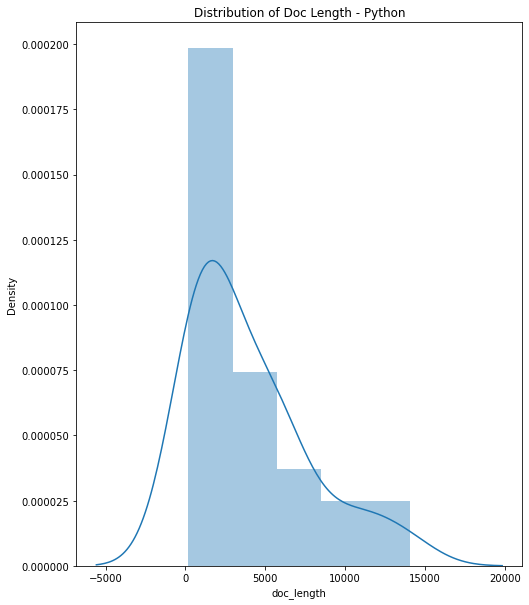

In [23]:
# T-tests assume that the continous variable is normally distributed,
# so we need to do a quick check of this.

sns.distplot(python_train.doc_length)
plt.title('Distribution of Doc Length - Python')
plt.show()

In [24]:
python_train.describe()

,doc_length
count,29.000000
mean,3952.862069
std,3762.644850
min,182.000000
25%,1085.000000
50%,2352.000000
75%,5452.000000
max,14084.000000


***

`Python Data is NOT evenly distributed`

***

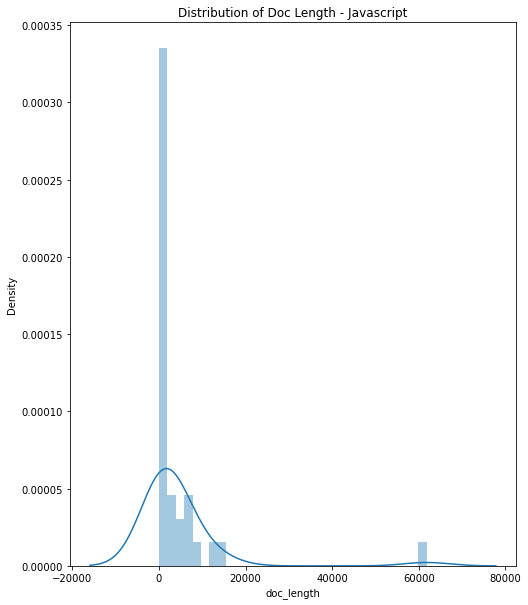

In [25]:
# T-tests assume that the continous variable is normally distributed,
# so we need to do a quick check of this.

sns.distplot(javascript_train.doc_length)
plt.title('Distribution of Doc Length - Javascript')
plt.show()

In [26]:
javascript_train.describe()

,doc_length
count,34.000000
mean,4475.588235
std,10774.717186
min,37.000000
25%,583.750000
50%,1166.000000
75%,3735.000000
max,61828.000000


***

`Javascript Data is NOT evenly distributed`

***

In [27]:
# Variance (2 Sample T-Test)
print(python_train.doc_length.var())
print(javascript_train.doc_length.var())

14157496.266009852
116094530.43137257


***
`Variance is not equal, need to set in function call`
***

#### Null and Alternate

In [28]:
null = "there is not a statisically significant difference between between the length of python repo README.md and javascript repo README.md"
alternate = "there is a statisically significant difference between between the length of python repo README.md and javascript repo README.md"

In [29]:
# I want a 95% confidence interval
alpha = 0.05

#### T-Test

In [30]:

t, p = stats.ttest_ind(python_train.doc_length , javascript_train.doc_length, equal_var =False)

print(f't = {t:.3f}')
print(f'p = {p:.3f}')
print("is p < alpha? ", p < alpha)
print("is t > 0? ", t > 0)
if p > alpha:
    print(f"We fail to reject that {null}")
elif t < 0:
    print(f"We fail to reject that {null}")
else:
    print(f"WE REJECT that {null}")


t = -0.265
p = 0.793
is p < alpha?  False
is t > 0?  False
We fail to reject that there is not a statisically significant difference between between the length of python repo README.md and javascript repo README.md


***

In [31]:
python_train.shape, javascript_train.shape

((29, 3), (34, 3))

### Question #4. Do different programming languages use a different number of unique words?

In [32]:
# Create list of word lists(python_train)
pwords = [re.sub(r'([^a-z0-9\s]|\s.\s)', '', doc).split() for doc in python_train.text_filtered]
# Combine those lists in to a single list
pwords = list(itertools.chain.from_iterable(pwords))


# Create list of word lists(javascript_train)
jwords = [re.sub(r'([^a-z0-9\s]|\s.\s)', '', doc).split() for doc in javascript_train.text_filtered]
# Combine those lists in to a single list
jwords = list(itertools.chain.from_iterable(jwords))

# Returns words unique to python
unique_pwords = list(set(pwords) - set(jwords))
# Returns words unique to javascript
unique_jwords = list(set(jwords) - set(pwords))

#### Words Unique to Python Repositories

In [33]:
print(len(unique_pwords))
unique_pwords

3004


['tokenlower',
 'c302',
 '298',
 'targetnational',
 'httpssourcereriofameuserownerrepoimages0httpssourcereriofameuserownerrepolinks0',
 'deeptxt',
 'slows',
 'trading',
 'pythonscript',
 'relationship',
 'yellow',
 'iamgetrolepolicy',
 'repo2docker',
 'unifi',
 'russiannorth',
 'sn',
 'deeplearningflappybird',
 '1759',
 'supercharged',
 'df',
 'textitself',
 'specialized',
 'zimmermann2018',
 'upstream',
 'preserved',
 'hesitate',
 'neuraldoodle',
 'mymodulesrcfooc',
 'tagrename',
 'pythonprompttoolkit',
 'pstatsstats',
 'group123',
 'legend',
 '4005',
 'tagbox',
 'formatinti',
 'annoying',
 'supervised',
 'partystates',
 'sword',
 'commaai',
 'csv',
 'hazarikamihalceacambriaalexander',
 'recently',
 'helpful',
 'highfrequency',
 'runsh',
 'httpsblogalyaccokr2315',
 'rolename1',
 'evolve',
 'sign',
 'ent',
 'matrix',
 'perl',
 'interactivity',
 'importance',
 'numberdigit',
 'fulltextreplaceitem',
 'jupyterrepo2docker',
 'gitapython3',
 'cython',
 'reposync',
 'skullcanyon',
 'plttitle

In [34]:
print(len(unique_jwords))
unique_jwords

2683


['bodyforeachfunctiondb',
 'clover',
 'yeelight',
 'easierenable',
 'masterrefactor',
 'autodiscover',
 '20244',
 '15347',
 'grinkevicius',
 'classp3',
 'itll',
 'matt',
 '06',
 'intrinsically',
 'dustinwilsontap',
 'wing',
 'dht',
 'listing',
 'isolated',
 'ssdmonitorzs6sr',
 'dbviewwithlistdesignname',
 'excludenonflow',
 'consolelogbody',
 'authenticity',
 'nanorequestopts',
 'nanodbinfofunctionerr',
 'historical',
 'v8',
 'failure3',
 'progressive',
 'alan',
 'formatdoc',
 'newstate',
 'angularmodulemyapp',
 'transforms',
 'ipfsdhtprovidecid',
 'supervision',
 'cve20207598',
 'srcthe',
 'rplbadgeup',
 'incrementally',
 'badgeup',
 'cidqmpilwkd6ysemwdtghegb8t7wvs7zwgygyvfj7dgnt2viq',
 'dimminglight',
 'abortsignal',
 'submithttplocalhostpathtopostbugto',
 'nanoauthusername',
 'httpsgithubcomprobonopdesp8266hueemulator',
 'storing',
 '040',
 'vlad',
 'ipfsconfiggetkey',
 'quirk',
 'nanorelaxopts',
 '9e5a',
 'integritysha3845bxrcw9kyxxnsmboohzraqa7z0pqwiaocgeg327zit1hz5lzcebimxlwkpreu

***
#### Takwaway:
`There appear to be more words unique to python repositories.  This makes sense because the length of python README.md text is statistically longer then javascript README.md text.`
***

## Modeling:

In [35]:
train.head()

,language,text_filtered,doc_length
29,javascript,reduxcode companion repo course udemy,37
85,javascript,npmhub npmhub browser extension let explore np...,580
45,javascript,archived content repo merged ipfsjsipfs please...,9651
5,python,ipython productive interactive computing overv...,3431
28,javascript,github doc repository contains documentation w...,1806


In [36]:
#Baseline
train.language.value_counts()

javascript    34
python        29
Name: language, dtype: int64

In [37]:
# Baseline prediction javascript
baseline = round(len(train[train.language == 'javascript']) / len(train), 2)
baseline

0.54

In [38]:
# Baseline prediction python
baseline = round(len(train[train.language == 'python']) / len(train), 2)
baseline

0.46

In [39]:
#Import some clean data for modeling
urls = acquire.get_urls()
df = acquire.get_readme_articles(urls=urls, cached=True)
df = prepare.clean_data(df)
train, validate, test = prepare.train_validate_test(df)

#### Bag of Words Model

In [40]:
from sklearn.feature_extraction.text import CountVectorizer

# Create CountVectorizer, which create bag-of-words model.
# stop_words : Specify language to remove stopwords. 
# min_df: ignore terms that have a document frequency strictly 
# lower than the given threshold. This value is also called cut-off in the literature. 
# If float, the parameter represents a proportion of documents, integer absolute counts. 
# ngram_range: the lower and upper boundary of the range of n-values for 
# different word n-grams or char n-grams to be extracted. 

vectorizer = CountVectorizer(stop_words='english', 
                             min_df=20, 
                             ngram_range=(1,2), 
                             binary=True)

# Learn vocabulary in sentences. 
vectorizer.fit(train.text_filtered)
# Transform each sentences in vector space.
bow = vectorizer.transform(train.text_filtered)

#### TF-IDF

In [44]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(stop_words='english', min_df=20, 
                             ngram_range=(1,2), 
                             binary=True)

tfidf_sparse_matrix = tfidf.fit_transform(train.text_filtered)

***

#### Train (Bag of Words)

In [45]:
from sklearn.linear_model import LogisticRegression

# Define x and y variable
X_bow = bow
y = train['language']

lm = LogisticRegression().fit(X_bow, y)

train['predicted'] = lm.predict(X_bow)

In [46]:
# Results(train)
pd.crosstab(train.language, train.predicted)

predicted,javascript,python
language,,
javascript,33,1
python,5,24


In [47]:
from sklearn.metrics import confusion_matrix, classification_report

print(classification_report(train.language, train.predicted))

              precision    recall  f1-score   support

  javascript       0.87      0.97      0.92        34
      python       0.96      0.83      0.89        29

    accuracy                           0.90        63
   macro avg       0.91      0.90      0.90        63
weighted avg       0.91      0.90      0.90        63



#### Train (TF-IDF)

In [48]:
# Define x and y variable


X_tfidf = tfidf_sparse_matrix
y = train['language']

lm_tfidf = LogisticRegression().fit(X_tfidf, y)
train['pred_tfidf'] = lm_tfidf.predict(X_tfidf)

In [49]:
# Results(train)
pd.crosstab(train.language, train.predicted)

predicted,javascript,python
language,,
javascript,33,1
python,5,24


In [50]:
print(classification_report(train.language, train.predicted))

              precision    recall  f1-score   support

  javascript       0.87      0.97      0.92        34
      python       0.96      0.83      0.89        29

    accuracy                           0.90        63
   macro avg       0.91      0.90      0.90        63
weighted avg       0.91      0.90      0.90        63



#### Validate

In [ ]:
# Validate
bow = vectorizer.transform(validate.text_filtered)
X_bow_validate = bow
y = validate['language']
validate['predicted'] = lm.predict(X_bow_validate)

In [ ]:
# Results(validate)
pd.crosstab(validate.language, validate.predicted)

In [ ]:
print(classification_report(validate.language, validate.predicted))

#### Test

In [ ]:
# Validate
# bow = vectorizer.transform(test.text_filtered)
# X_bow_test = bow
# y = test['language']
# test['predicted'] = lm.predict(X_bow_test)